<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model selection



## Install libraries

Note: After installing the libraries for the first time restart the runtime (CTRL + M) for the new versions of the library to be loaded.

In [1]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 2.7MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774864 sha256=4a34226a5d57cd8a4c0b792195bdb7d89cfb48494e8da2ca31302f06c2fe5cd1
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=3c46be2be8166e1b9f1dc927ed7cac74428baefae9a95f6d10ba275ef1d595e9
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 18.4MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119314 sha256=e2a34

## Custom Functions

In [1]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True,rmse=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=1

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,150,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    # Root mean squared error
    if rmse:
      from pysurvival.utils.display import compare_to_actual

      rmse_result = compare_to_actual(model, X_test, T_test, E_test,
                                  is_at_risk = False,  figure_size=(16, 6),
                                  metrics = ['rmse'])


    #return results
    results = pd.DataFrame({'c_index':[c_index],
                            'ibs':[ibs],
                            'mean_auc':[mean_auc],
                            'rmse':[rmse_result['root_mean_squared_error']]})
    return results

## Load Data

In [2]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Create Train, Test and Eval datasets

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA
data_statistics = raw_data.describe()

## Remove negative time
raw_data = raw_data[raw_data['time']>=0]

for feature in ['products_created','admin_visits','tx','gmv_usd']:

  # Remove data with the quantiles method
  q1 = data_statistics[feature]['25%']
  q3 = data_statistics[feature]['75%']
  iqr = q3 - q1
  raw_data = raw_data[~((raw_data[feature] < (q1 - 1.5 * iqr)) | (raw_data[feature] > (q3 + 1.5 * iqr))) ]

  # Remove data with the std method
  raw_data = raw_data[raw_data[feature] <= (data_statistics[feature]['mean'] + 3 * data_statistics[feature]['std'])]


## Remove gmv_usd feature
raw_data.drop(['gmv_usd'], axis=1, inplace=True)

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Model Selection

In [4]:
import pandas as pd
# Create empty dataframe for storing the results

results = pd.DataFrame()

### Standard CoxPH model

/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7126


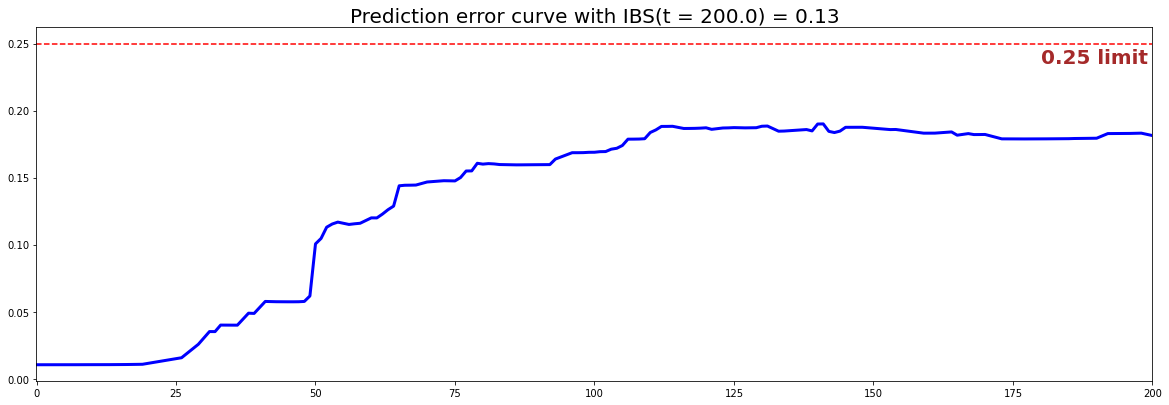

IBS: 0.1348
AUC: 0.7896


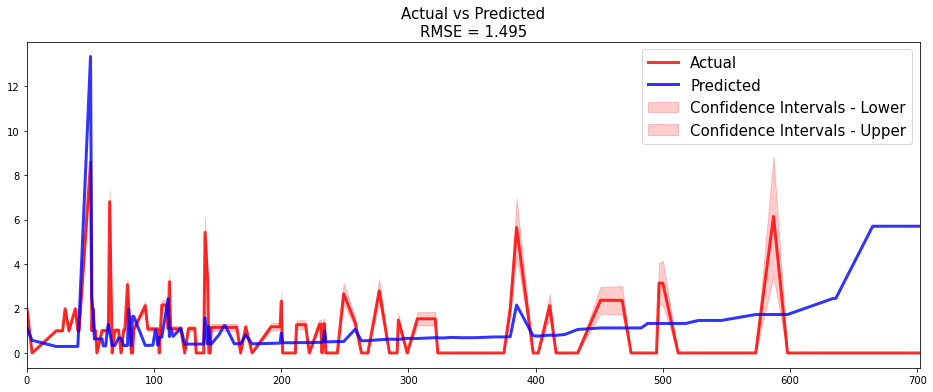

,c_index,ibs,mean_auc,rmse,model
0,0.712618,0.134811,0.789575,1.494939,coxph


In [5]:
from pysurvival.models.semi_parametric import CoxPHModel
import pandas as pd

# Creating an instance of the Cox PH model and fitting the data.

## Build the model
coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.1, l2_reg=1e-2, init_method='zeros',verbose=False)

## Evaluate model
tmp_results = evaluate_model(coxph,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['coxph']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### DeepSurv/Non-Linear CoxPH model

c-index: 0.7086


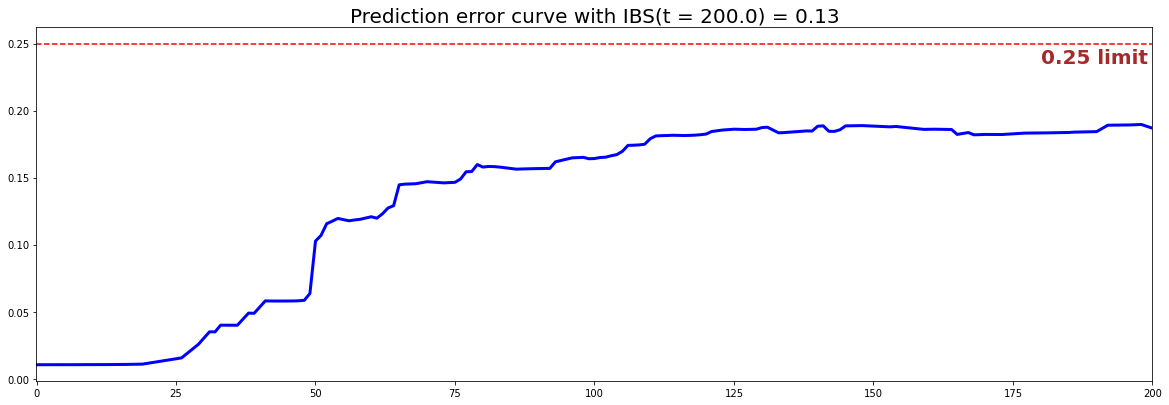

IBS: 0.1350
AUC: 0.7933


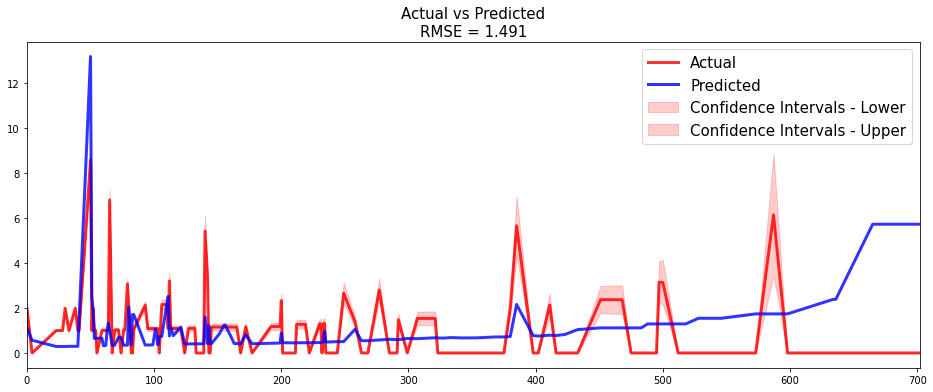

,c_index,ibs,mean_auc,rmse,model
0,0.712618,0.134811,0.789575,1.494939,coxph
1,0.708571,0.134964,0.793294,1.491036,nonlinear_coxph


In [6]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
import pandas as pd

# Creating an instance of the NonLinear CoxPH model and fitting the data.

### Defining the MLP structure. Here we will build a 1-hidden layer 
### with 150 units and `BentIdentity` as its activation function
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]

## Build the model
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform')

## Evaluate model
tmp_results = evaluate_model(nonlinear_coxph,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['nonlinear_coxph']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Linear MTLR model

c-index: 0.5098


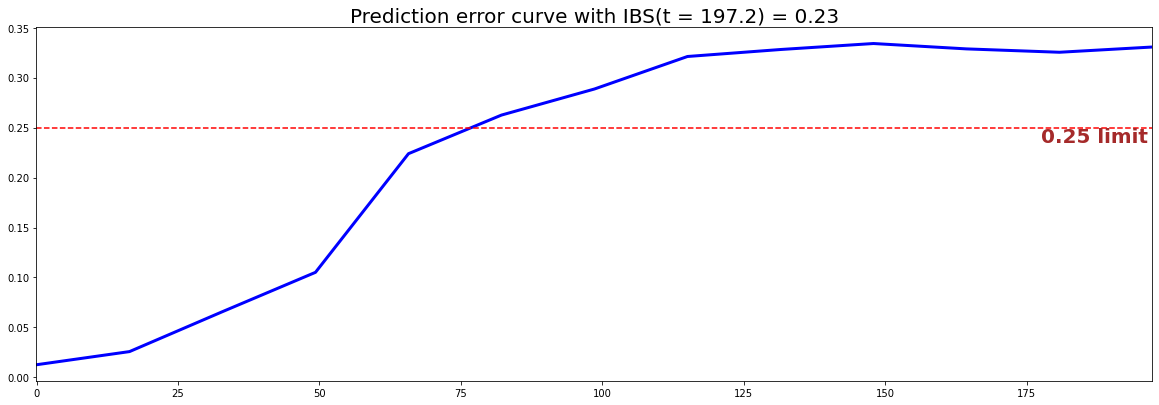

IBS: 0.2318
AUC: 0.5086


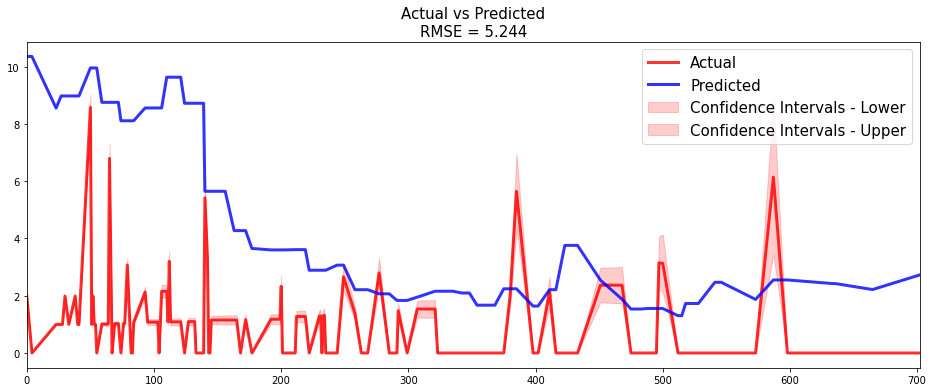

,c_index,ibs,mean_auc,rmse,model
0,0.712618,0.134811,0.789575,1.494939,coxph
1,0.708571,0.134964,0.793294,1.491036,nonlinear_coxph
2,0.509815,0.231805,0.508568,5.243674,l_mtlr


In [7]:
from pysurvival.models.multi_task import LinearMultiTaskModel
import pandas as pd

# Creating an instance of the Linear MTLR model and fitting the data.

## Build the model
l_mtlr = LinearMultiTaskModel(bins=50)
l_mtlr.fit(X_train, T_train, E_train, lr=0.00001, l2_reg=0.001, init_method='orthogonal')

## Evaluate model
tmp_results = evaluate_model(l_mtlr,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['l_mtlr']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Neural MTLR model

c-index: 0.6891


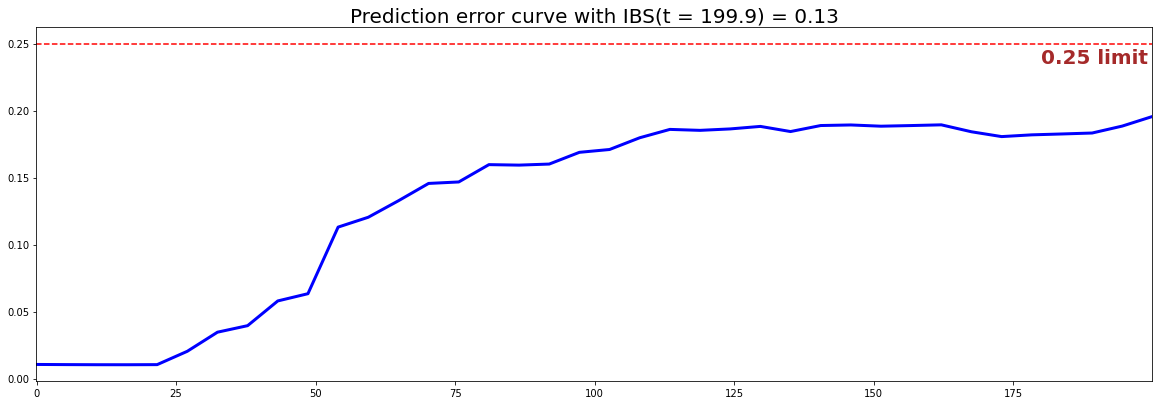

IBS: 0.1349
AUC: 0.7693


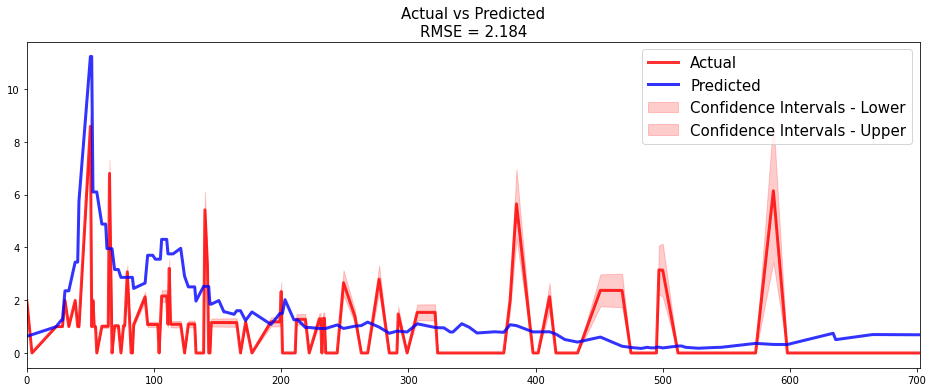

,c_index,ibs,mean_auc,rmse,model
0,0.712618,0.134811,0.789575,1.494939,coxph
1,0.708571,0.134964,0.793294,1.491036,nonlinear_coxph
2,0.509815,0.231805,0.508568,5.243674,l_mtlr
3,0.689087,0.134936,0.769332,2.183759,n_mtlr


In [8]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
import pandas as pd

#### 4 - Creating an instance of the Neural MTLR model and fitting the data.

# Defining the MLP structure. Here we will build a 1-hidden layer 
# with 150 units and `Swish` as its activation function
structure = [ {'activation': 'ReLU', 'num_units': 150},  ]

# Building the model
n_mtlr = NeuralMultiTaskModel(structure=structure, bins=150)
n_mtlr.fit(X_train, T_train, E_train, 
            lr=0.00001, l2_reg=0.001, num_epochs = 500,
           init_method='orthogonal', optimizer = 'sgd')

## Evaluate model
tmp_results = evaluate_model(n_mtlr,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['n_mtlr']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Parametric Weibull Model

c-index: 0.6378


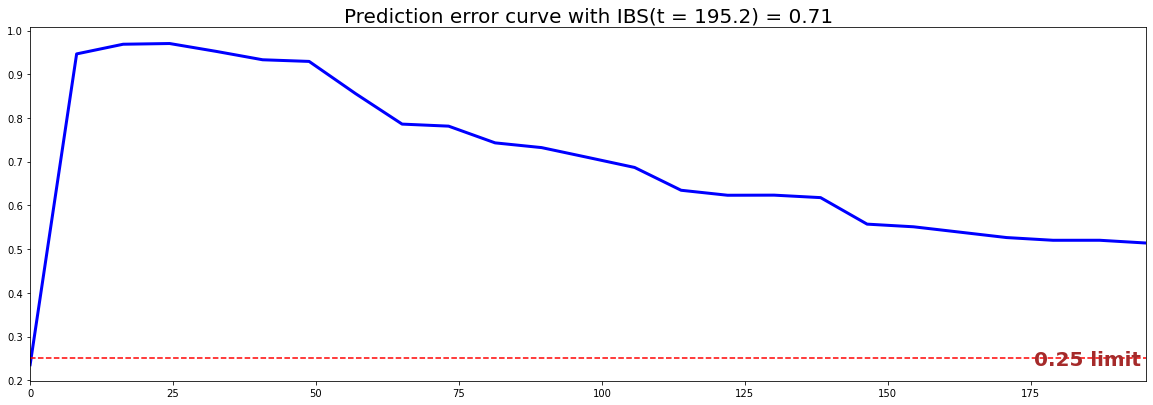

IBS: 0.7118
AUC: 0.6906


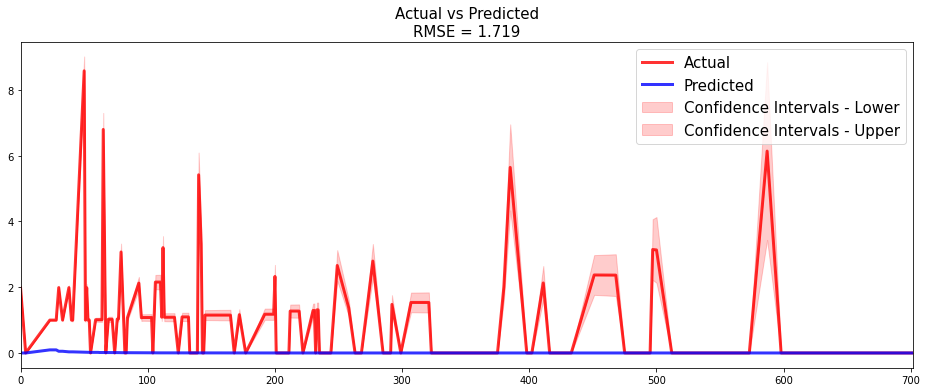

,c_index,ibs,mean_auc,rmse,model
0,0.712618,0.134811,0.789575,1.494939,coxph
1,0.708571,0.134964,0.793294,1.491036,nonlinear_coxph
2,0.509815,0.231805,0.508568,5.243674,l_mtlr
3,0.689087,0.134936,0.769332,2.183759,n_mtlr
4,0.637762,0.711823,0.690578,1.719333,weib


In [9]:
from pysurvival.models.parametric import WeibullModel
import pandas as pd

# Creating an instance of the weibertz model and fitting the data.

## Build the model
weib = WeibullModel()
weib.fit(X_train, T_train, E_train, lr=0.0001, init_method='zeros',
    optimizer ='adam', l2_reg = 0.001, num_epochs=2000)

## Evaluate model
tmp_results = evaluate_model(weib,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['weib']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Random Survival Forest model

c-index: 0.6869


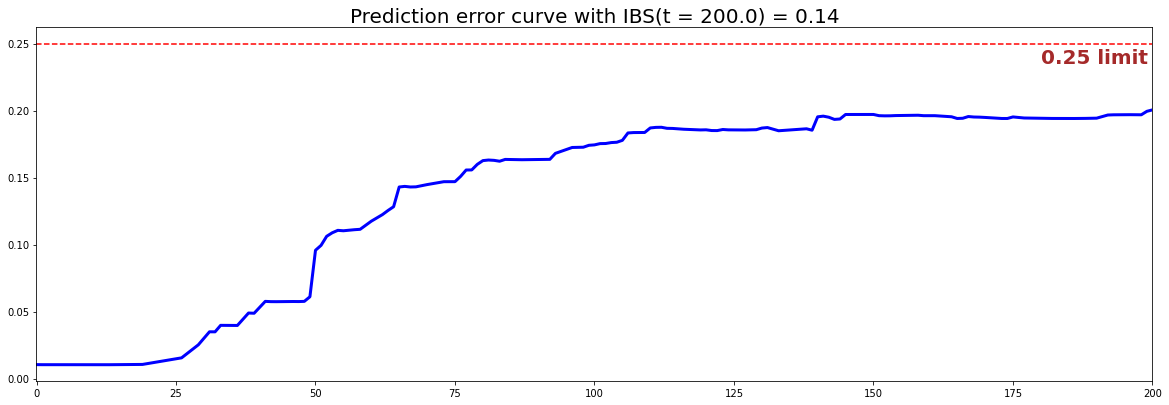

IBS: 0.1388
AUC: 0.7565


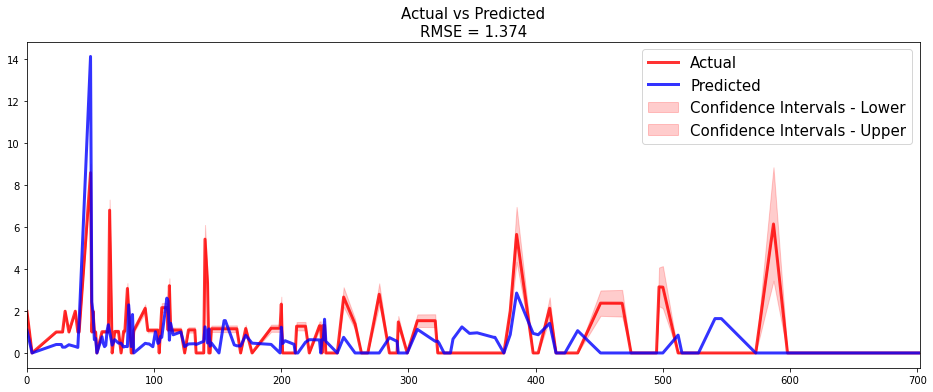

,c_index,ibs,mean_auc,rmse,model
0,0.712618,0.134811,0.789575,1.494939,coxph
1,0.708571,0.134964,0.793294,1.491036,nonlinear_coxph
2,0.509815,0.231805,0.508568,5.243674,l_mtlr
3,0.689087,0.134936,0.769332,2.183759,n_mtlr
4,0.637762,0.711823,0.690578,1.719333,weib


In [10]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd

## Build the model
rsf = RandomSurvivalForestModel(num_trees=50)
rsf.fit(X_train, T_train, E_train,
        max_features="sqrt", max_depth=5, min_node_size=20)

## Evaluate model
tmp_results = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['model'] = ['rsf']
results = pd.concat([results, tmp_results], ignore_index=True)
results.head()

### Evaluate Results

In [13]:
# Show results table

results.round(2).head(10)

,c_index,ibs,mean_auc,rmse,model
0,0.71,0.13,0.79,1.49,coxph
1,0.71,0.13,0.79,1.49,nonlinear_coxph
2,0.51,0.23,0.51,5.24,l_mtlr
3,0.69,0.13,0.77,2.18,n_mtlr
4,0.64,0.71,0.69,1.72,weib
5,0.69,0.14,0.76,1.37,rsf


In [12]:
print('max c_index is on line:{}'.format(results['c_index'].idxmax()))
print('max mean_auc is on line:{}'.format(results['mean_auc'].idxmax()))
print('min ibs is on line:{}'.format(results['ibs'].idxmin()))
print('min rmse is on line:{}'.format(results['rmse'].idxmin()))

max c_index is on line:0
max mean_auc is on line:1
min ibs is on line:0
min rmse is on line:5


In [14]:
results.iloc[[0,1,5],:]

,c_index,ibs,mean_auc,rmse,model
0,0.712618,0.134811,0.789575,1.494939,coxph
1,0.708571,0.134964,0.793294,1.491036,nonlinear_coxph
5,0.686909,0.138848,0.756524,1.374035,rsf
